<a href="https://colab.research.google.com/github/Sharif2138/Intro_to_ML_Summative/blob/main/Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install kaggle CLI
!pip install kaggle

In [ ]:
#uploading kaggle token file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharifkiviiri","key":"49648c580abb165d5ee35772bb65bd96"}'}

In [ ]:
#moving the file to kaggle config folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download dataset
!rm -rf dataset*
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
!unzip skin-cancer-malignant-vs-benign.zip -d ./dataset >/dev/null 2>&1
!ls

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
 91% 295M/325M [00:00<00:00, 464MB/s]
100% 325M/325M [00:00<00:00, 518MB/s]
dataset  drive	kaggle.json  sample_data  skin-cancer-malignant-vs-benign.zip


In [ ]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.test.gpu_device_name()

2.19.0


''

In [ ]:
#Tf.data pipeline for making data ready for training
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf # Explicitly import tensorflow

train_dataset = Path("/content/dataset/train")
all_train_images = list(train_dataset.glob('*/*.jpg'))
all_train_labels = [path.parent.name for path in all_train_images]

# Corrected test_dataset path: Removed double slash and changed 'test' to 'Test' (capitalized)
test_dataset = Path("/content/dataset/test")
all_test_images = list(test_dataset.glob('*/*.jpg'))
all_test_labels = [path.parent.name for path in all_test_images]

#encoding the labels
encoder = LabelEncoder()
all_train_labels_encoded = encoder.fit_transform(all_train_labels)
all_test_labels_encoded = encoder.transform(all_test_labels)

num_classes = len(encoder.classes_)

#splitting the data into train and val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_train_images,
    all_train_labels_encoded,
    test_size =0.2,
    random_state = 42,
    stratify = all_train_labels_encoded
)

# Convert Path objects to strings
train_paths = [str(path) for path in train_paths]
val_paths = [str(path) for path in val_paths]
all_test_images = [str(path) for path in all_test_images]

#forming a tf.data datasets
train_data = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((all_test_images, all_test_labels_encoded))


#function to load the images
def load_images(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [128,128])
  img = img / 255.0

  return img, label

#preprocess
Batch_size = 32
autotune = tf.data.AUTOTUNE

train_data = train_data.map(load_images, num_parallel_calls = autotune)
val_data = val_data.map(load_images, num_parallel_calls = autotune)
test_data = test_data.map(load_images, num_parallel_calls = autotune)

#data augmentation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

def augment(img, label):
    return data_aug(img, training=True), label

#CPU and GPU optimizatitions
train_data = train_data.shuffle(1000).batch(Batch_size).map(augment, num_parallel_calls=autotune).prefetch(autotune)
val_data = val_data.batch(Batch_size).prefetch(autotune)
test_data = test_data.batch(Batch_size).prefetch(autotune)


for imgs, labels in train_data.take(1):
  print(f"image_shape: {imgs.shape}")
  print(f"labels_shape: {labels.shape}")

image_shape: (32, 128, 128, 3)
labels_shape: (32,)


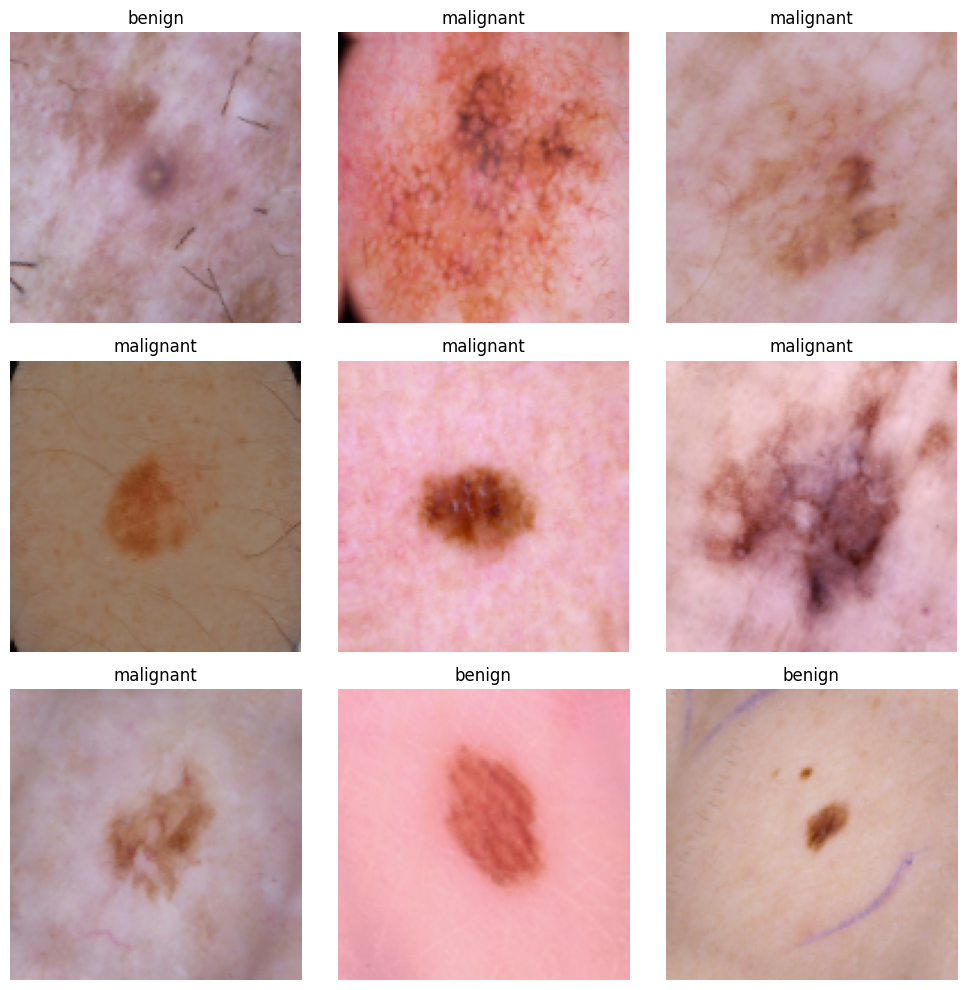

In [ ]:
#visualise some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_name = encoder.classes_[labels[i]]
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()

#**Classical ML**

In [ ]:
#convert datasets to one dimension thats needed to feed in classical ML
import numpy as np

# Function to convert tf.data dataset to numpy arrays
def tfdata_to_numpy(dataset):
    all_images = []
    all_labels = []
    for imgs, labels in dataset:
        all_images.append(imgs.numpy())
        all_labels.append(labels.numpy())

    # Concatenate all batches
    images_combined = np.concatenate(all_images, axis=0)
    labels_combined = np.concatenate(all_labels, axis=0)

    return images_combined, labels_combined

X_train, y_train = tfdata_to_numpy(train_data)
X_val, y_val     = tfdata_to_numpy(val_data)
X_test, y_test   = tfdata_to_numpy(test_data)

print("Train shape:", X_train.shape, y_train.shape)

#Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Flattened shape:", X_train_flat.shape)


Train shape: (2109, 128, 128, 3) (2109,)
Flattened shape: (2109, 49152)


#**Experiment 1**

In [ ]:
#Train SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib

model_svm = SVC(kernel = "linear", C = 0.1)
model_svm.fit(X_train_flat, y_train)

y_pred = model_svm.predict(X_val_flat)

print (classification_report(y_pred, y_val))

# Save the model
joblib.dump(model_svm, 'svm_model.joblib')
print ("model saved successfully")

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       295
           1       0.71      0.73      0.72       233

    accuracy                           0.75       528
   macro avg       0.74      0.75      0.75       528
weighted avg       0.75      0.75      0.75       528

model saved successfully


#**Experiment 2**

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf_model_A = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model_A.fit(X_train_flat, y_train)
y_pred = rf_model_A.predict(X_val_flat)

print (classification_report(y_pred, y_val))

# Save the model
joblib.dump(rf_model_A, 'rf_model_A.joblib')
print ("model saved successfully")

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       257
           1       0.87      0.77      0.81       271

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528

model saved successfully


#**Experiment 3**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model_B = RandomForestClassifier(n_estimators = 500, random_state=42 )
rf_model_B.fit(X_train_flat, y_train)
y_pred = rf_model_B.predict(X_val_flat)

print (classification_report(y_pred, y_val))

# Save the model
joblib.dump(rf_model_B, 'rf_model_B.joblib')
print ("model saved successfully")

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       255
           1       0.88      0.77      0.82       273

    accuracy                           0.82       528
   macro avg       0.83      0.83      0.82       528
weighted avg       0.83      0.82      0.82       528

model saved successfully


#**Experiment 4**

In [ ]:
#Use embeddings from MobileNet with random forest
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier

base_model = MobileNetV2(weights='imagenet', input_shape=(128,128,3), include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

base_model.trainable = False

# Extract embeddings
X_train_emb = feature_extractor.predict(X_train)
X_val_emb   = feature_extractor.predict(X_val)
X_test_emb   = feature_extractor.predict(X_test)


rf_model_C = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_model_C.fit(X_train_emb, y_train)
y_pred = rf_model_C.predict(X_val_emb)

print (classification_report(y_pred, y_val))

# Save the model
joblib.dump(rf_model_C, 'rf_model_C.joblib')
print ("model saved successfully")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       278
           1       0.86      0.82      0.84       250

    accuracy                           0.85       528
   macro avg       0.85      0.85      0.85       528
weighted avg       0.85      0.85      0.85       528

model saved successfully


#**Deep Learning**


In [ ]:
#Function to build iterative experiments of advanced CNN models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

def build_advanced_cnn(lr=0.001, dropout=0.5, regulizer = 0.001):

    model = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(regulizer), input_shape=(128,128,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(regulizer)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(regulizer)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(regulizer)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


#early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

#**Experiment 5**

In [ ]:
#higher Learning late
model_A = build_advanced_cnn(lr=0.001, dropout=0.5, regulizer = 0.0001)

history_A = model_A.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks = early_stopping
)

#save model
model_A.save('/content/drive/MyDrive/summative_models/model_A.h5')
print('model_A saved successfully')

#save history
import pickle

with open("history_A.pkl", "wb") as f:
    pickle.dump(history_A.history, f)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.7376 - loss: 0.9118 - val_accuracy: 0.5455 - val_loss: 14.4299
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.7798 - loss: 0.5571 - val_accuracy: 0.5455 - val_loss: 27.7963
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8111 - loss: 0.5110 - val_accuracy: 0.5455 - val_loss: 32.1746
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8257 - loss: 0.4741 - val_accuracy: 0.5455 - val_loss: 35.7726
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8058 - loss: 0.4864 - val_accuracy: 0.5492 - val_loss: 14.0730
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.7969 - loss: 0.5090 - val_accuracy: 0.7727 - val_loss: 0.5936
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8197 - loss: 0.4622 - val_accuracy: 0.8087 - val_loss: 0.6573
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8145 - loss: 0.4721 - val_accuracy: 0.6667 - 

model_A saved successfully


#**Experiment 6**

In [ ]:
#Lower learning rate
model_B = build_advanced_cnn(lr=0.0001, dropout=0.5, regulizer = 0.001)

history_B = model_B.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks = early_stopping
)

#save model
model_B.save('/content/drive/MyDrive/summative_models/model_B.h5')
print('model_B saved successfully')

#save history
import pickle

with open("history_B.pkl", "wb") as f:
    pickle.dump(history_B.history, f)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.7440 - loss: 1.3725 - val_accuracy: 0.5455 - val_loss: 2.3396
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8056 - loss: 1.1097 - val_accuracy: 0.5455 - val_loss: 3.0765
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.8033 - loss: 1.0586 - val_accuracy: 0.5455 - val_loss: 3.3308
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8167 - loss: 1.0217 - val_accuracy: 0.5455 - val_loss: 3.3457
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8272 - loss: 0.9603 - val_accuracy: 0.5473 - val_loss: 2.5960
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8391 - loss: 0.9557 - val_accuracy: 0.5663 - val_loss: 2.2762
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8396 - loss: 0.9419 - val_accuracy: 0.5909 - val_loss: 1.8676
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8459 - loss: 0.9262 - val_accuracy: 0.7311

model_B saved successfully


In [ ]:
#print metrics
best_val_acc = max(history_B.history['val_accuracy'])
best_val_loss = min(history_B.history['val_loss'])

print(best_val_acc, best_val_loss)


y_true = []
y_pred = []
y_prob = []

for images, labels in val_data:
    probs = model_B.predict(images, verbose=0)
    preds = (probs > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())
    y_prob.extend(probs.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", auc)


0.8863636255264282 0.6270971298217773
Precision: 0.8781512605042017
Recall: 0.8708333333333333
F1-score: 0.8744769874476988
ROC-AUC: 0.9561631944444444


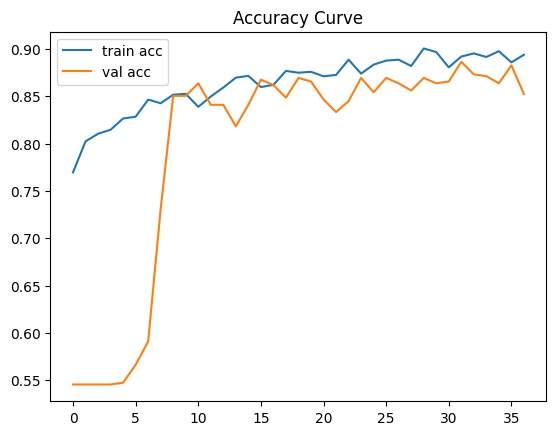

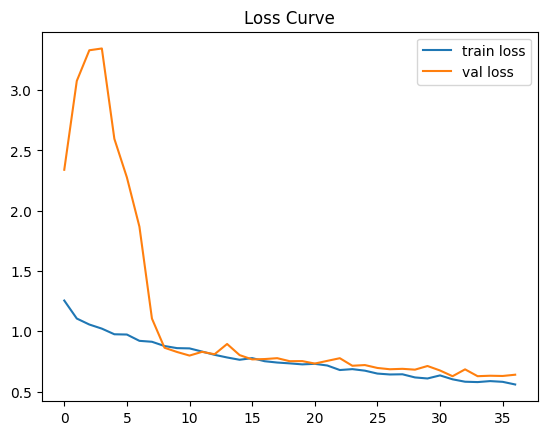

In [ ]:
#Plot val accuracy and loss curves
plt.plot(history_B.history["accuracy"], label="train acc")
plt.plot(history_B.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history_B.history["loss"], label="train loss")
plt.plot(history_B.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss Curve")
plt.show()



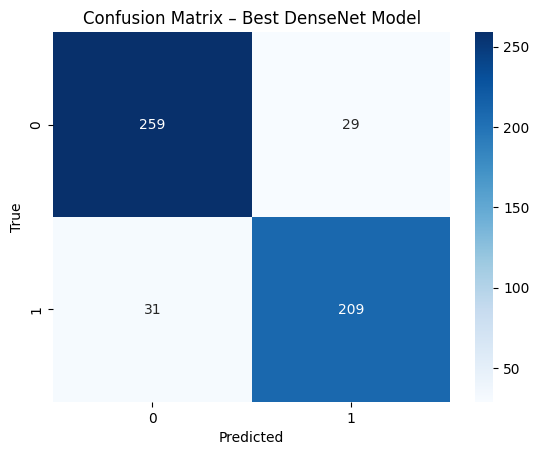

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best DenseNet Model")
plt.show()

#**Experiment 7**

In [ ]:
#more regularization with dropout with 0.7
model_C = build_advanced_cnn(lr=0.0001, dropout=0.7, regulizer = 0.01)

history_C = model_C.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks = early_stopping
)

#save model
model_C.save('/content/drive/MyDrive/summative_models/model_C.h5')
print('model_C saved successfully')

#save history
import pickle

with open("history_C.pkl", "wb") as f:
    pickle.dump(history_C.history, f)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.7219 - loss: 7.0637 - val_accuracy: 0.5455 - val_loss: 7.8466
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7849 - loss: 6.1843 - val_accuracy: 0.5455 - val_loss: 8.2694
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7810 - loss: 5.5390 - val_accuracy: 0.5455 - val_loss: 8.5482
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7831 - loss: 5.0601 - val_accuracy: 0.5455 - val_loss: 7.4646
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8158 - loss: 4.5810 - val_accuracy: 0.5455 - val_loss: 6.8188
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7879 - loss: 4.2544 - val_accuracy: 0.5492 - val_loss: 5.3765
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.7861 - loss: 3.9526 - val_accuracy: 0.5739 - val_loss: 4.6080
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8149 - loss: 3.6061 - val_accuracy: 0.604

model_C saved successfully


In [ ]:
#print metrics
best_val_acc = max(history_C.history['val_accuracy'])
best_val_loss = min(history_C.history['val_loss'])

print(best_val_acc, best_val_loss)


y_true = []
y_pred = []
y_prob = []

for images, labels in val_data:
    probs = model_C.predict(images, verbose=0)
    preds = (probs > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())
    y_prob.extend(probs.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", auc)


0.875 0.8217248320579529
Precision: 0.8648648648648649
Recall: 0.8
F1-score: 0.8311688311688312
ROC-AUC: 0.9331597222222222


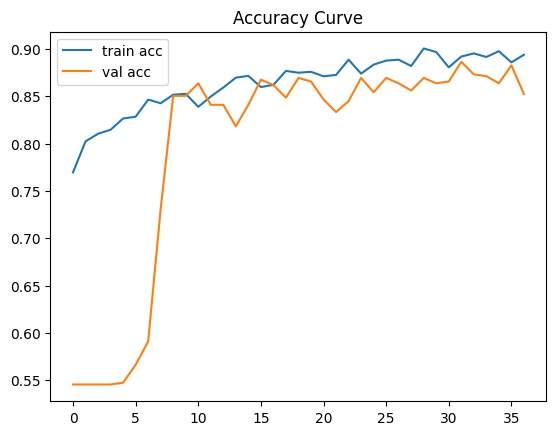

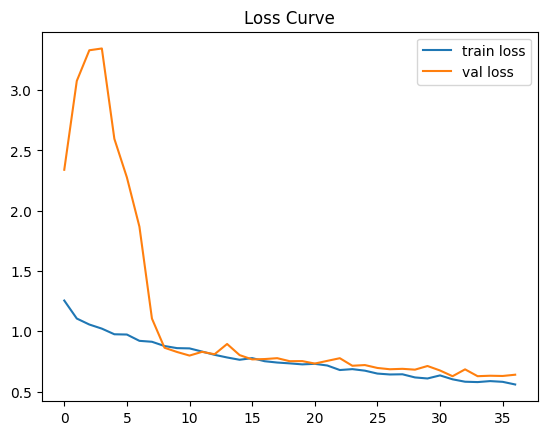

In [ ]:
#Plot val accuracy and loss curves
plt.plot(history_B.history["accuracy"], label="train acc")
plt.plot(history_B.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history_B.history["loss"], label="train loss")
plt.plot(history_B.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss Curve")
plt.show()



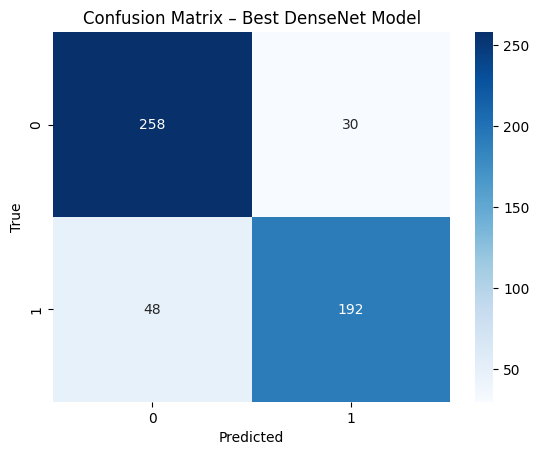

In [ ]:
#plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best DenseNet Model")
plt.show()

#**Experiment 8**

In [ ]:
#transfer learning with mobileNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

mobilenet_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mobilenet_model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_mobilenet = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks = early_stopping
)

#save model
mobilenet_model.save('/content/drive/MyDrive/summative_models/mobilenet_model.h5')
print('mobilenet_model saved successfully')

#save history
import pickle

with open("/content/drive/MyDrive/summative_models/history_mobilenet.pkl", "wb") as f:
    pickle.dump(history_mobilenet.history, f)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.6690 - loss: 0.6341 - val_accuracy: 0.8352 - val_loss: 0.3940
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.7953 - loss: 0.4480 - val_accuracy: 0.8447 - val_loss: 0.3656
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8163 - loss: 0.3969 - val_accuracy: 0.8011 - val_loss: 0.3847
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8248 - loss: 0.3824 - val_accuracy: 0.8428 - val_loss: 0.3526
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8136 - loss: 0.3893 - val_accuracy: 0.8390 - val_loss: 0.3491
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8430 - loss: 0.3534 - val_accuracy: 0.8523 - val_loss: 0.3485
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8395 - loss: 0.3396 - val_accuracy: 0.8277 - val_loss: 0.3675
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8636 - loss: 0.3272 - val_accuracy: 0.84

mobilenet_model saved successfully


In [ ]:
#print metrics
best_val_acc = max(history_mobilenet.history['val_accuracy'])
best_val_loss = min(history_mobilenet.history['val_loss'])

print(best_val_acc, best_val_loss)


y_true = []
y_pred = []
y_prob = []

for images, labels in val_data:
    probs = mobilenet_model.predict(images, verbose=0)
    preds = (probs > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())
    y_prob.extend(probs.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", auc)


In [ ]:
#Plot val accuracy and loss curves
plt.plot(history_B.history["accuracy"], label="train acc")
plt.plot(history_B.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history_B.history["loss"], label="train loss")
plt.plot(history_B.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [ ]:
#plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best DenseNet Model")
plt.show()

#**Experiment 9**

In [ ]:

#added L2 regularization
mobilenet_model = tf.keras.Sequential([
    base_model,

    tf.keras.layers.GlobalAveragePooling2D(),

    # L2 added here
    tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001)
    )
])

mobilenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_mobilenet = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=early_stopping
)

# Save model
mobilenet_model.save('/content/drive/MyDrive/summative_models/mobilenet_model.h5')
print('mobilenet_model saved successfully')

# Save history
import pickle

with open("/content/drive/MyDrive/summative_models/history_mobilenet.pkl", "wb") as f:
    pickle.dump(history_mobilenet.history, f)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.6758 - loss: 0.9126 - val_accuracy: 0.8201 - val_loss: 0.5598
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8032 - loss: 0.5916 - val_accuracy: 0.8333 - val_loss: 0.5181
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8009 - loss: 0.5542 - val_accuracy: 0.8258 - val_loss: 0.5085
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8310 - loss: 0.5090 - val_accuracy: 0.8333 - val_loss: 0.4757
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8364 - loss: 0.4775 - val_accuracy: 0.8371 - val_loss: 0.4626
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8326 - loss: 0.4550 - val_accuracy: 0.8201 - val_loss: 0.4845
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8368 - loss: 0.4437 - val_accuracy: 0.8333 - val_loss: 0.4409
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8612 - loss: 0.4247 - val_accuracy: 0.778

mobilenet_model saved successfully
